Connected to thermal (Python 3.11.5)

In [1]:
# -*- coding: utf-8 -*-
# Go back to root directory of project.
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from skimage.measure import label

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from mercury_duckling.datasets.transforms import OneHotEncodeFromBlobs
from mercury_duckling.samplers import ClickerSampler, BaseSampler, RandomPointSampler

In [3]:
def show_mask(
        mask, ax,
        color=np.array([30/255, 144/255, 255/255, 0.6]),
        random_color=False
    ):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1], 
        color='green', 
        marker='o', 
        s=marker_size, 
        edgecolor='black', 
        linewidth=1.25,
        alpha=1
    )
    ax.scatter(
        neg_points[:, 0], 
        neg_points[:, 1], 
        color='red', 
        marker='X',
        s=marker_size, 
        edgecolor='black', 
        linewidth=1.25,
        alpha=1
    )   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [4]:
image = cv2.imread(
    '../../data/_500_per_folder/Infrared_Images/IR_05/IR05_31.jpg'
)
mask = cv2.imread(
    '../../data/_500_per_folder/Delamination_labeling/IR_05/IR05_31.png'
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [5]:
target = label(target)
target = OneHotEncodeFromBlobs()(target).transpose(2, 0, 1)

In [6]:
image.dtype

dtype('uint8')

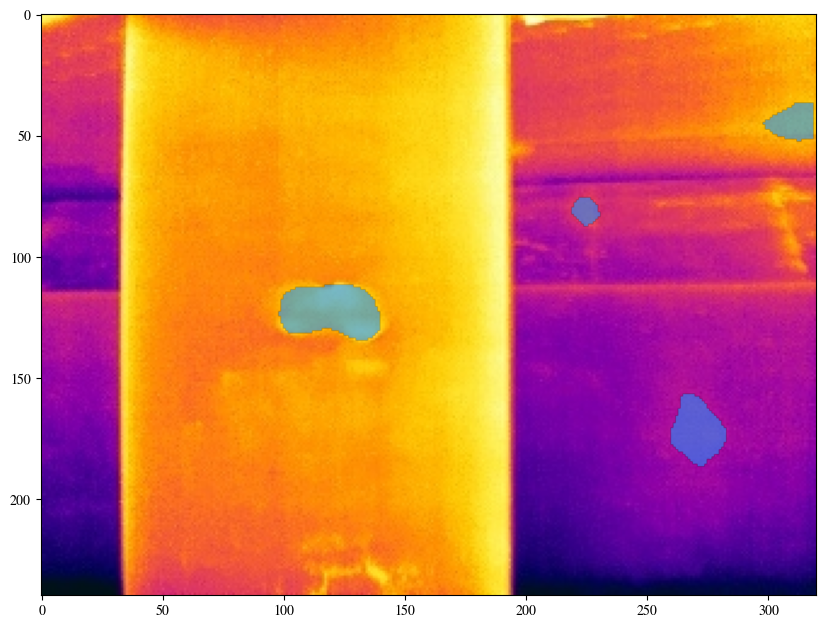

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in target:
    show_mask(mask.astype(bool), plt.gca())
plt.axis('on')
plt.show()

# Basic Sampler

In [8]:
sampler = BaseSampler()

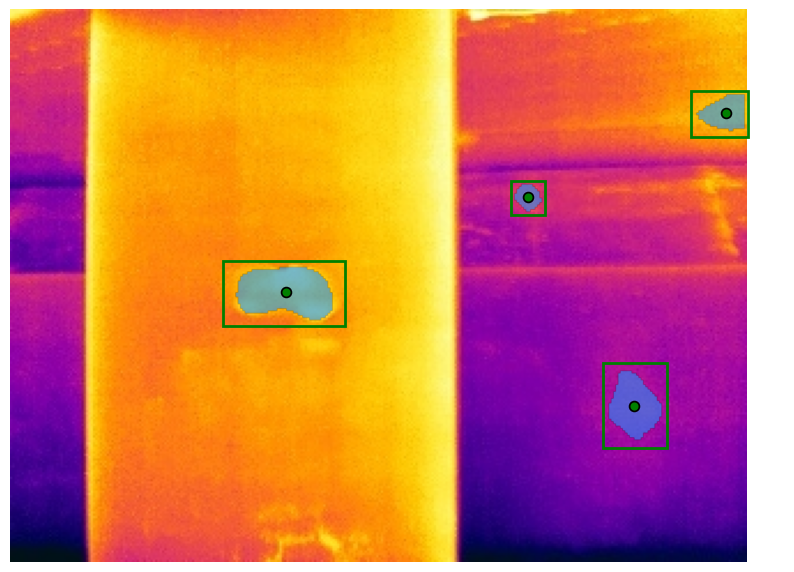

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in target:
    show_mask(mask.astype(bool), plt.gca(), random_color=False)
    for prompts in sampler.interact(mask):
        coords = np.array([prompt['coords'] for prompt in prompts])
        labels = np.array([prompt['label'] for prompt in prompts])
        show_points(coords, labels, plt.gca(), marker_size=50)
    for prompts in sampler.interact(mask, type='bbox'):
        show_box(prompts[0]['coords'], plt.gca())
plt.axis('off')
plt.show()

## Random Point Sampler

In [10]:
sampler = RandomPointSampler(point_count=(1, 5))

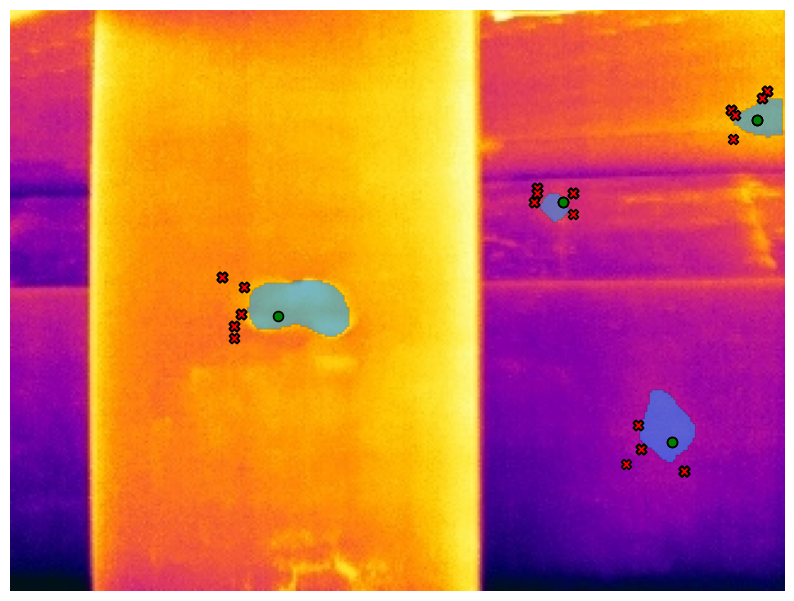

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in target:
    show_mask(mask.astype(bool), plt.gca(), random_color=False)
    for prompts in sampler.interact(mask):
        coords = np.array([prompt['coords'] for prompt in prompts])
        labels = np.array([prompt['label'] for prompt in prompts])
        show_points(coords, labels, plt.gca(), marker_size=50)
plt.axis('off')
plt.show()

# Integration with SAM

In [12]:
def prepare_prompts(prompts):
    sam_prompts = defaultdict(list)
    for prompt in prompts:
        if prompt["type"] == "point":
            sam_prompts["point_coords"].append(prompt["coords"])
            sam_prompts["point_labels"].append(prompt["label"])
        elif prompt["type"] == "bbox":
            sam_prompts["bbox"].append(prompt["coords"])
        elif prompt["type"] == "logits":
            sam_prompts["mask_input"].append(prompt["mask"])
        else:
            warn(f"Ignoring invalid prompt type: {prompt['type']}.")
    
    for prompt, val in sam_prompts.items():
        sam_prompts[prompt] = np.array(val)
    return sam_prompts

In [13]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [14]:
sampler = ClickerSampler(click_limit = 6)
masks_color = np.array([30/225, 225/225, 100/225, 0.6])
iou_score = lambda y_hat, y : np.logical_and(y_hat, y).sum() / np.logical_or(y_hat, y).sum()
for i, mask in enumerate(np.array(target)):
    logits = None
    for prompts in sampler.interact(mask):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        coords = np.array([prompt['coords'] for prompt in prompts])
        labels = np.array([prompt['label'] for prompt in prompts])
        show_points(coords, labels, plt.gca(), marker_size=100)
        if logits is not None:
            prompts[-1]["mask"] = logits
        sam_prompts = prepare_prompts(prompts)
        masks, scores, logits = predictor.predict(
            **sam_prompts,
            multimask_output=False
        )
        sampler.set_outputs(masks[0])
        iou = iou_score(masks[0], mask)
        show_mask(masks[0], plt.gca(), color=masks_color)
        show_mask(mask, plt.gca())
        # plt.title(
        #     f"Mask {i+1}, SAM IoU: {scores[0]:.3f}, IoU: {iou:.3f}",
        #     fontsize=12
        # )
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(
            f"/home/gramos/Projects/MIIA-A23/results/interactive/clicker_examples/sam/{i+1}_{len(prompts)}.png",
            bbox_inches='tight'
        )
        plt.close()
        # plt.show()


/tmp/ipykernel_388614/1770371148.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


# Integration with RITM

In [15]:
import torch
import sys

sys.path.append('./mercury_duckling/models/')

from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample
from isegm.inference.predictors import get_predictor
from isegm.inference.clicker import Clicker, Click

device = torch.device('cpu')

In [16]:
MODEL_NAME = "coco_lvis_h18_itermask"
WEIGHTS_URL = "./checkpoints"
EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(WEIGHTS_URL, MODEL_NAME)
print(f"Found checkpoint: {checkpoint_path}")
# Fix for numpy.int being deprecated since numpy 1.20
np.int = np.int_
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'NoBRS'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)
# predictor.set_input_image(image)

Found checkpoint: checkpoints/coco_lvis_h18_itermask.pth


In [17]:
def prepare_prompts_ritm(prompts):
    clicker = Clicker(gt_mask=None, init_clicks=None)
    for prompt in prompts:
        if prompt["type"] == "point":
            # coords are in (y, x) format
            points = Click(is_positive=prompt["label"], coords=prompt["coords"][::-1])
            clicker.add_click(points)
        else:
            warn(f"Ignoring invalid prompt type: {prompt['type']}.")
    return clicker

In [18]:
sampler = ClickerSampler(click_limit = 6)
masks_color = np.array([30/225, 225/225, 100/225, 0.6])
iou_score = lambda y_hat, y : np.logical_and(y_hat, y).sum() / np.logical_or(y_hat, y).sum()
predictions = np.zeros(image.shape[:2])
for i, mask in enumerate(np.array(target)):
    # h, w = mask.shape[-2:]
    logits = None
    predictor.set_input_image(image)
    for prompts in sampler.interact(mask):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        coords = np.array([prompt['coords'] for prompt in prompts])
        labels = np.array([prompt['label'] for prompt in prompts])
        show_points(coords, labels, plt.gca(), marker_size=100)
        ritm_clicker = prepare_prompts_ritm(prompts)
        if isinstance(logits, np.ndarray):
            logits = torch.tensor(logits).unsqueeze(0).unsqueeze(0)
        logits = predictor.get_prediction(ritm_clicker, logits)
        preds = logits > MODEL_THRESH
        sampler.set_outputs(preds)
        iou = iou_score(preds, mask)
        show_mask(preds, plt.gca(), color=masks_color)
        show_mask(mask, plt.gca())
        # plt.title(
        #     f"Mask {i+1}, IoU: {iou:.3f}",
        #     fontsize=16
        # )
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"/home/gramos/Projects/MIIA-A23/results/interactive/clicker_examples/ritm/{i+1}_{len(prompts)}.png",
            bbox_inches='tight')
        plt.close()

/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_388614/1647072231.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


# Integration with InteractiveUnet (Adobe)

In [19]:
import torch
import sys
sys.path.insert(0, './mercury_duckling/models/inter_unet/')

from networks.models import build_model
from networks.transforms import groupnorm_normalise_image, trimap_transform

class InterUnetArgs:
  encoder = 'resnet50_GN_WS'
  decoder = 'InteractiveSegNet'
  use_mask_input = True
  use_usr_encoder = True
  weights = './checkpoints/InterSegSynthFT.pth'
  device = 'cpu'
args=InterUnetArgs()
model = build_model(args)

modifying input layer


In [20]:
def scale_input(x: np.ndarray, scale_type) -> np.ndarray:
    ''' Scales so that min side length is 352 and sides are divisible by 8'''
    h, w = x.shape[:2]
    h1 = int(np.ceil(h / 32) * 32)
    w1 = int(np.ceil(w / 32) * 32)
    x_scale = cv2.resize(x, (w1, h1), interpolation=scale_type)
    return x_scale

def remove_non_fg_connected(alpha_np, fg_pos):

    if(np.count_nonzero(fg_pos) > 0):
        ys, xs = np.where(fg_pos == 1)

        alpha_np_bin = alpha_np > 0.5
        ret, labels_con = cv2.connectedComponents((alpha_np_bin * 255).astype(np.uint8))

        labels_f = []
        for y, x in zip(ys, xs):
            if(labels_con[y, x] != 0):
                labels_f.append(labels_con[y, x])
        fg_con = np.zeros_like(alpha_np)
        for lab in labels_f:
            fg_con[labels_con == lab] = 1

        alpha_np[fg_con == 0] = 0

    return alpha_np

def np_to_torch(x):
    return torch.from_numpy(x).permute(2, 0, 1)[None, :, :, :].float()

def pred(image_np: np.ndarray, trimap_np: np.ndarray, alpha_old_np: np.ndarray, model) -> np.ndarray:
    ''' Predict segmentation
        Parameters:
        image_np -- the image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        trimap_np -- two channel trimap/Click map, first background then foreground. Dimensions: (h, w, 2)
        Returns:
        alpha: alpha matte/non-binary segmentation image between 0 and 1. Dimensions: (h, w)
    '''
    # return trimap_np[:,:,1] + (1-np.sum(trimap_np,-1))/2
    alpha_old_np = remove_non_fg_connected(alpha_old_np, trimap_np[:, :, 1])

    h, w = trimap_np.shape[:2]
    image_scale_np = scale_input(image_np, cv2.INTER_LANCZOS4)
    trimap_scale_np = scale_input(trimap_np, cv2.INTER_NEAREST)
    alpha_old_scale_np = scale_input(alpha_old_np, cv2.INTER_LANCZOS4)

    with torch.no_grad():

        image_torch = np_to_torch(image_scale_np)
        trimap_torch = np_to_torch(trimap_scale_np)
        alpha_old_torch = np_to_torch(alpha_old_scale_np[:, :, None])

        trimap_transformed_torch = np_to_torch(trimap_transform(trimap_scale_np))
        image_transformed_torch = groupnorm_normalise_image(image_torch.clone(), format='nchw')

        alpha = model(image_transformed_torch, trimap_transformed_torch, alpha_old_torch, trimap_torch)
        alpha = cv2.resize(alpha[0].cpu().numpy().transpose((1, 2, 0)), (w, h), cv2.INTER_LANCZOS4)
    alpha[trimap_np[:, :, 0] == 1] = 0
    alpha[trimap_np[:, :, 1] == 1] = 1

    alpha = remove_non_fg_connected(alpha, trimap_np[:, :, 1])
    return alpha

In [21]:
def prepare_promtps_unet(prompts, trimap):
    for prompt in prompts:
        if prompt["type"] == "point":
            # coords are in (y, x) format
            trimap[*prompt["coords"][::-1], int(prompt['label'])] = 1
        else:
            warn(f"Ignoring invalid prompt type: {prompt['type']}.")
    return trimap

In [22]:
sampler = ClickerSampler(click_limit = 6)
h,w,c = image.shape
masks_color = np.array([30/225, 225/225, 100/225, 0.6])
iou_score = lambda y_hat, y : np.logical_and(y_hat, y).sum() / np.logical_or(y_hat, y).sum()
for i, mask in enumerate(np.array(target)):
    trimap = np.zeros((h,w,2))
    alpha = np.zeros((h,w))
    for prompts in sampler.interact(mask):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        coords = np.array([prompt['coords'] for prompt in prompts])
        labels = np.array([prompt['label'] for prompt in prompts])
        show_points(coords, labels, plt.gca(), marker_size=100)
        trimap = prepare_promtps_unet(prompts, trimap)
        alpha = pred(image/255.0, trimap, alpha, model)
        sampler.set_outputs(alpha)
        iou = iou_score(alpha.astype(bool), mask)
        show_mask(alpha, plt.gca(), color=masks_color)
        show_mask(mask, plt.gca())
        # plt.title(
        #     f"Mask {i+1}, IoU: {iou:.3f}",
        #     fontsize=12
        # )
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"/home/gramos/Projects/MIIA-A23/results/interactive/clicker_examples/unet/{i+1}_{len(prompts)}.png",
            bbox_inches='tight')
        plt.close()

/tmp/ipykernel_388614/671238379.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))
